# 0.0 IMPORTS


## 0.1 Libraries

In [4]:
import pandas as pd
import inflection 
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime
import matplotlib.gridspec as gridspec
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

## 0.2 Helper Functions

In [5]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 ,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))



## 0.3 Loading Data

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


# 1.0 PASSO 01 - DESCRICAO DOS DADOS


In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns


In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x) 
cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions


In [9]:
print('Number of rows: {}'.format (df1.shape[0]))
print('Number of rows: {}'.format (df1.shape[1]))

Number of rows: 1017209
Number of rows: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

# Mostrar colunas que tem valores NA

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA


In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
# competition_distance              2642

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval                  508031
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

m.columns = ['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kutosis']

In [18]:
m

,attibutes,min,max,range,mean,median,std,skew,kutosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

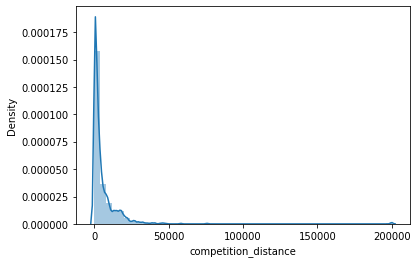

In [19]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

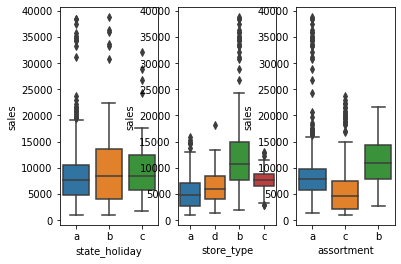

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)


# 2.0 PASSO 02 - FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

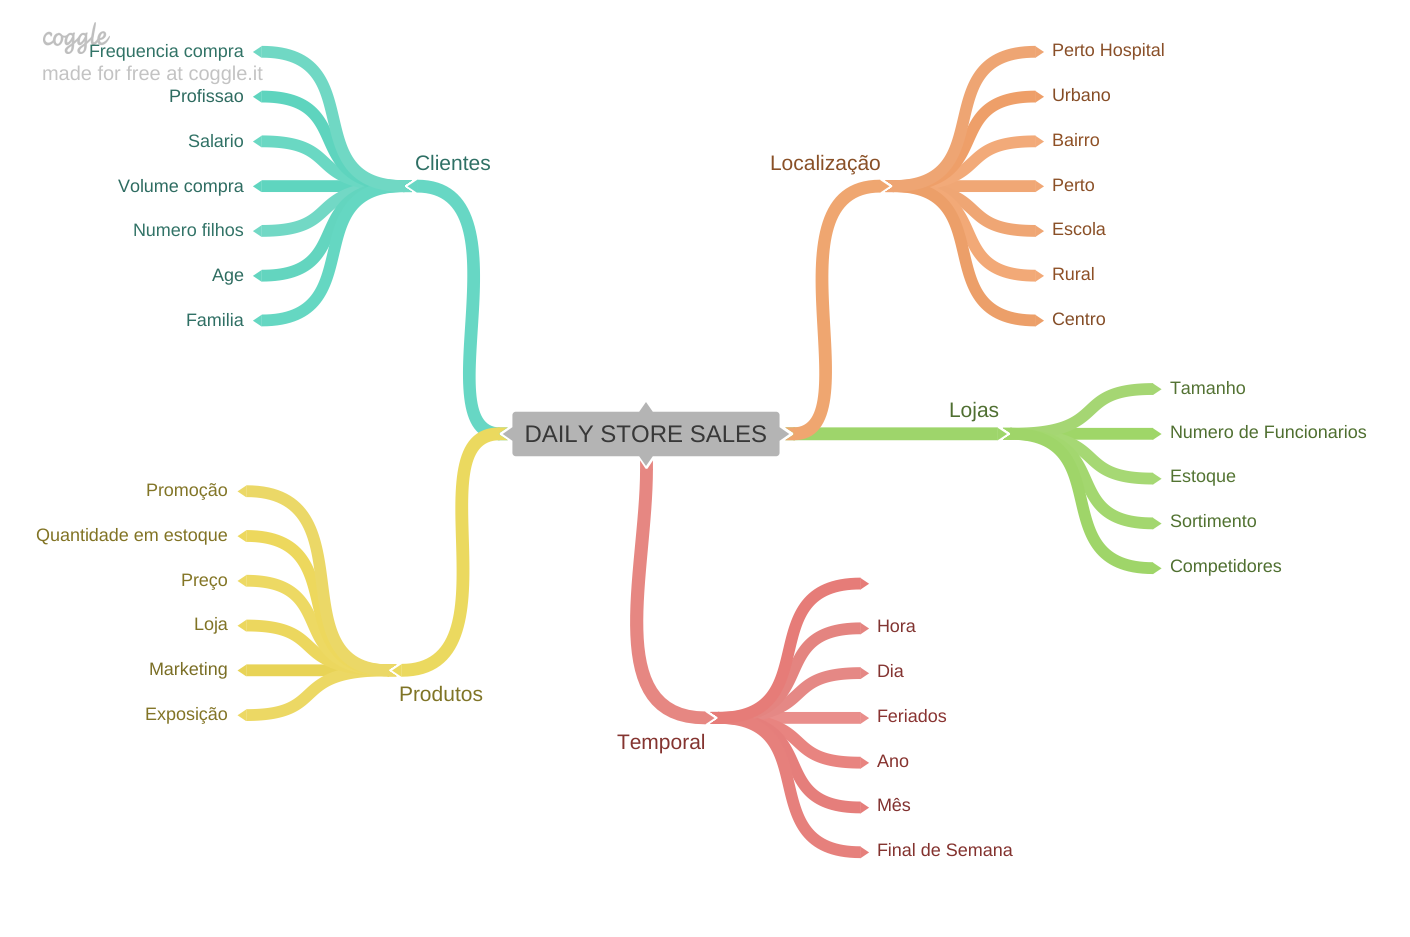

In [23]:
Image ('img/DAILY_STORE_SALES.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Lojas que tem promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas que tem mais promocoes consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas que abrem no feriado do Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos nos feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas que tem mais promocoes consecutivas deveriam vender mais.

**7.** Lojas que abrem no feriado do Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos nos feriados escolares.

## 2.4 Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime (x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DAS VARIÁVEIS

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [28]:
df3 = df3[(df3['open'] != 0) &  (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)


In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [31]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

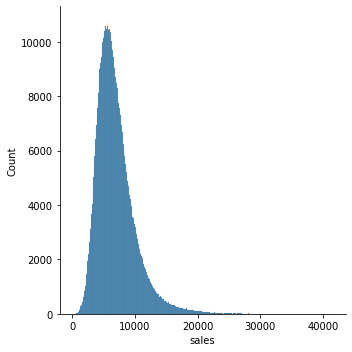

In [32]:
sns.displot(df4['sales'])

### 4.1.2 Numerical Variable

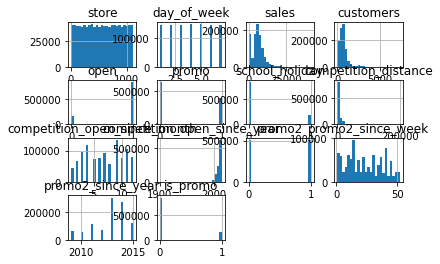

In [33]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [35]:
# State Holiday

df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


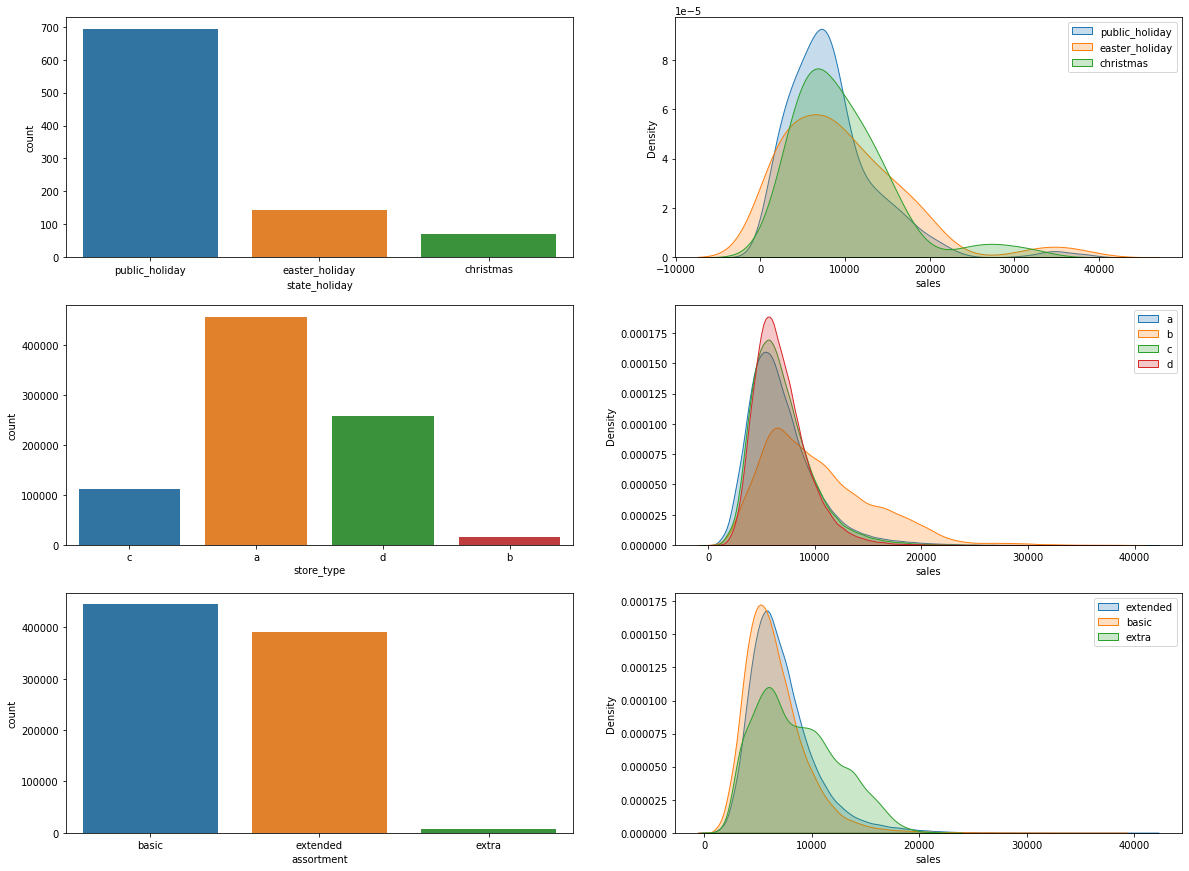

In [36]:

plt.figure(figsize=(20, 15))

# State Holiday

plt.subplot(3,2,1)

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

# Store type
plt.subplot(3,2,3)

sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()




## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.


**FALSA** Lojas com maior sortimento vendem menos


<AxesSubplot:xlabel='year_week'>

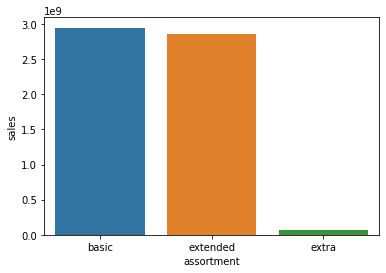

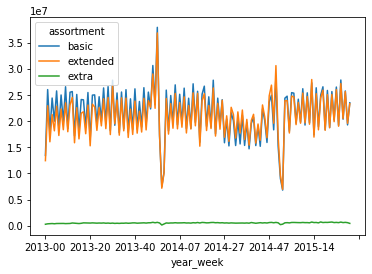

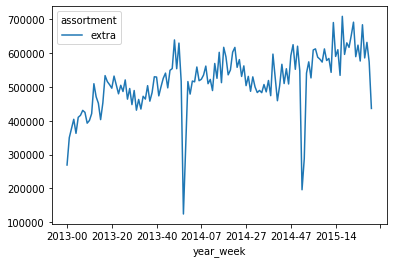

In [37]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


In [38]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### H2. Lojas com competidores mais proximos deveriam vender menos.


**FALSA** Lojas com competidores mais proximos vendem MAIS

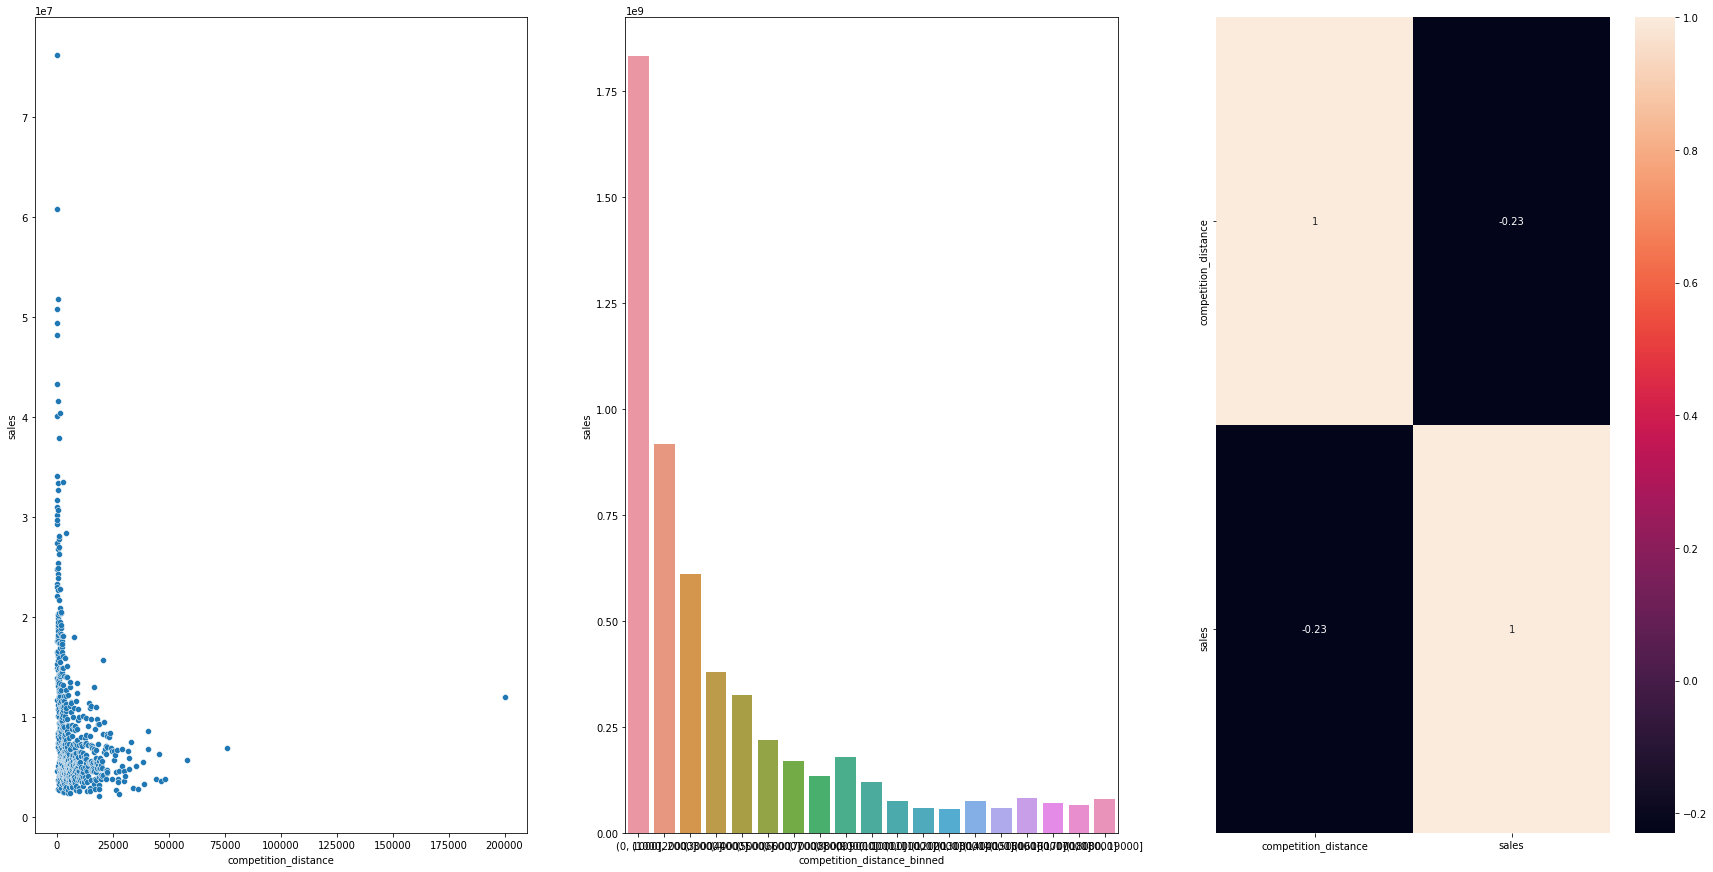

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

bins = list (np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores a mais tempo deveriam vender mais.

**FALSA** Lojas com competidores a mais tempo vendem MENOS

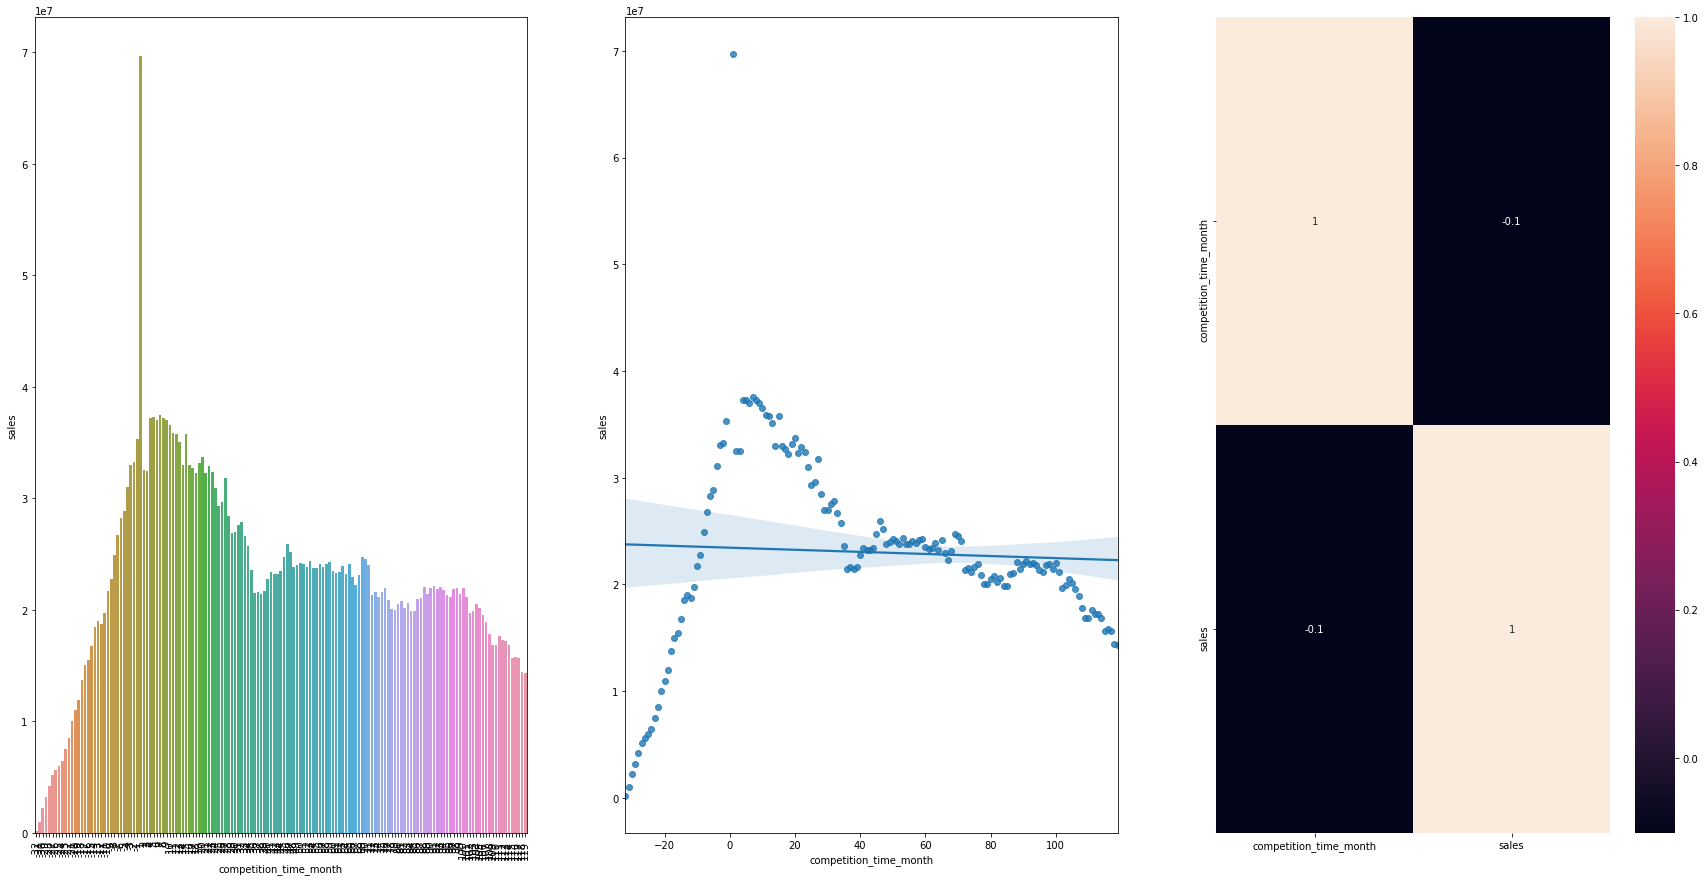

In [40]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4. Lojas com promocoes ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ativas por mais tempo vendem regularmente mais depois de um certo tempo elas decaem.

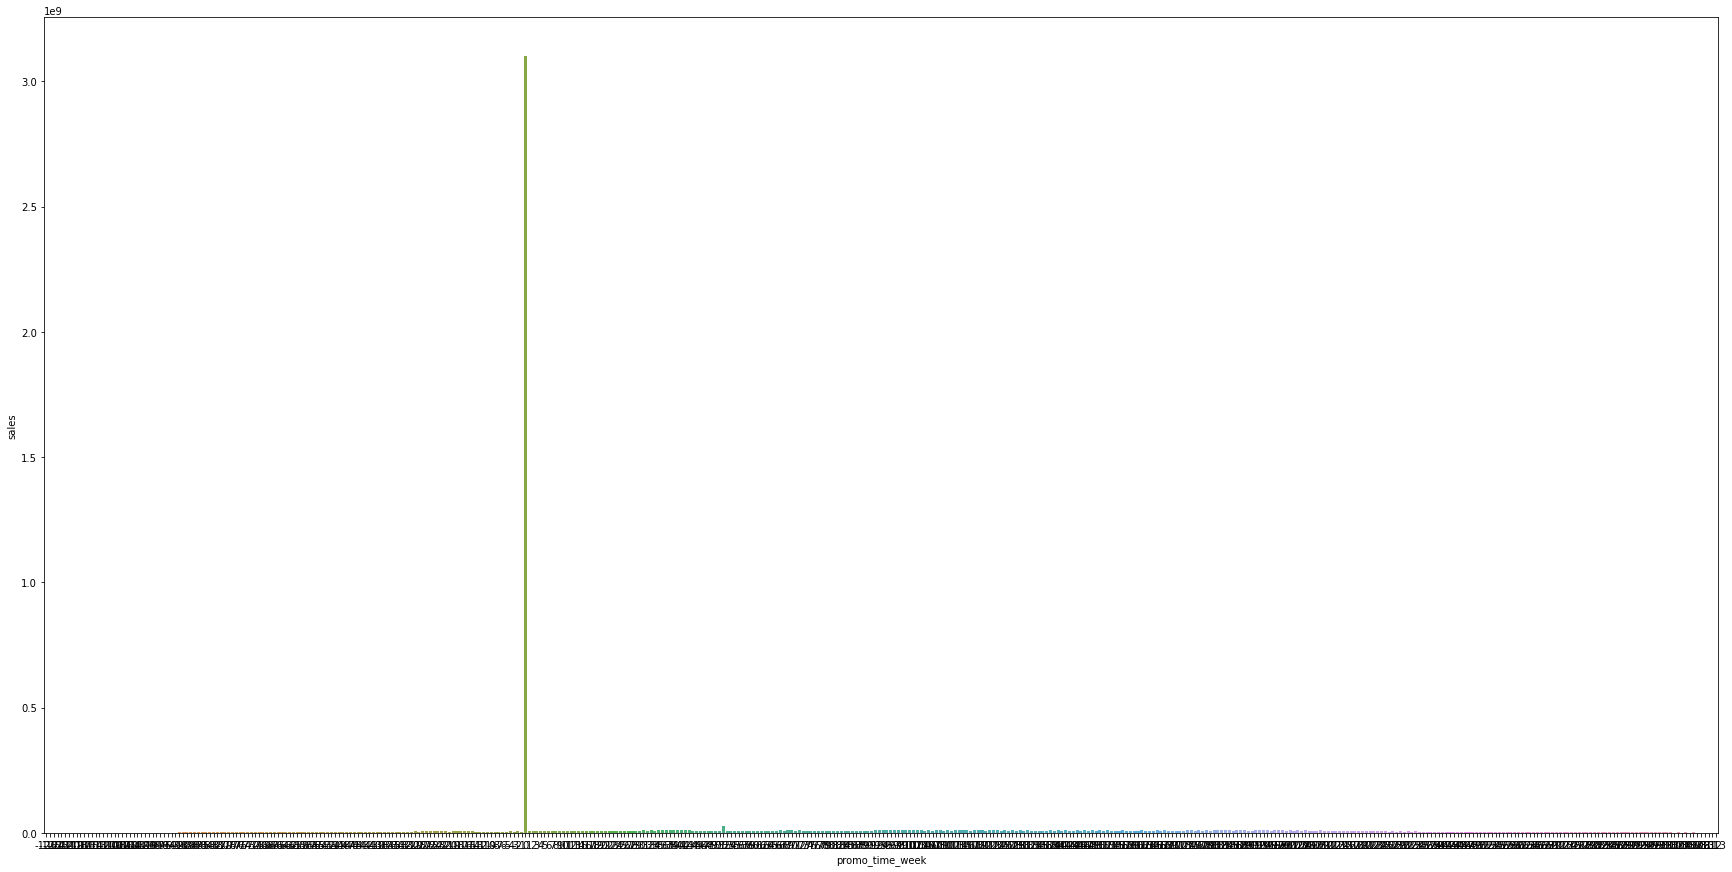

In [41]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index() 


plt.figure(figsize=(30, 15))
sns.barplot(x='promo_time_week', y='sales', data=aux1);  
    

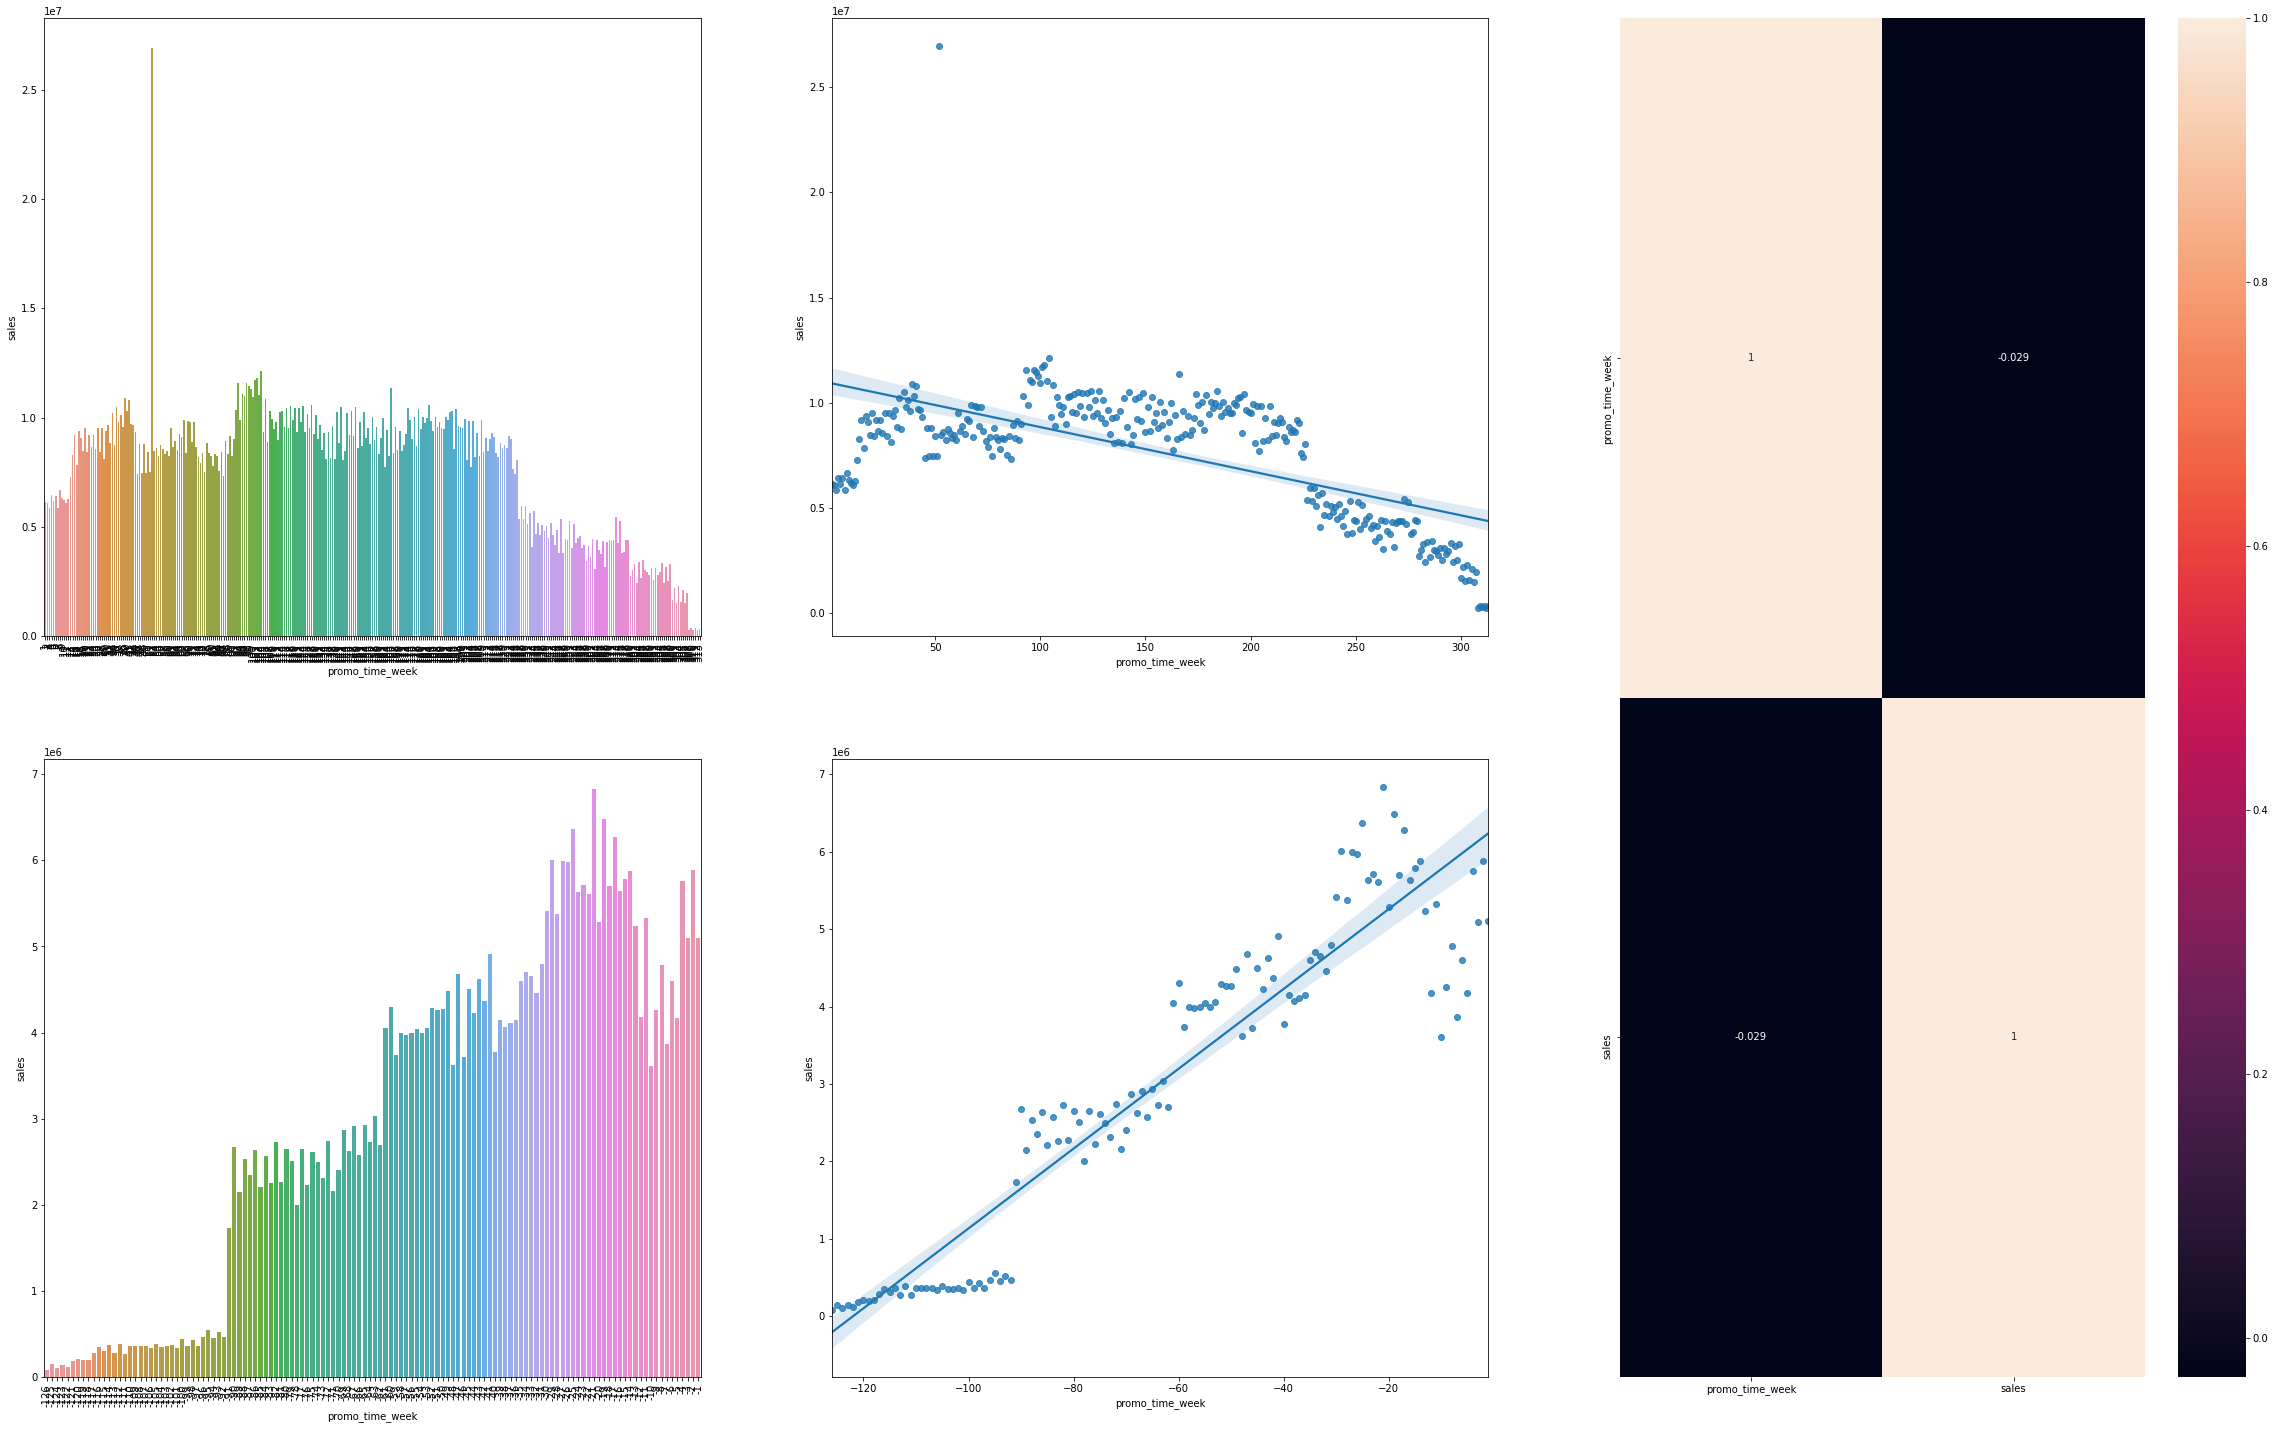

In [42]:
plt.figure(figsize=(40, 25))

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0]) 
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido 
sns.barplot(x='promo_time_week', y='sales', data=aux2); 
plt.xticks(rotation=90);  

plt.subplot(grid[0,1]) 
sns.regplot(x='promo_time_week', y='sales', data=aux2); 

plt.subplot(grid[1,0]) 
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular 
sns.barplot(x='promo_time_week', y='sales', data=aux3); 
plt.xticks(rotation=90);
    
plt.subplot(grid[1,1]) 
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com mais dias de promocao deveriam vender mais. <s>



### H6. Lojas que tem mais promocoes consecutivas deveriam vender mais.

**FALSA** Lojas com mais promocoes consecutivas vendem MENOS.

In [43]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


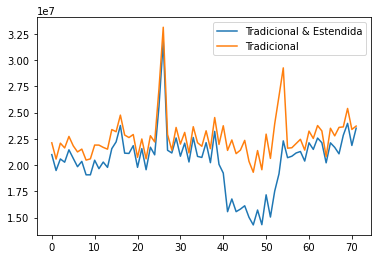

In [44]:
# 1
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Estendida', 'Tradicional'])

### H7. Lojas que abrem no feriado do Natal deveriam vender mais.

**FALSA**  Lojas que abrem no feriado do Natal vendem MENOS.

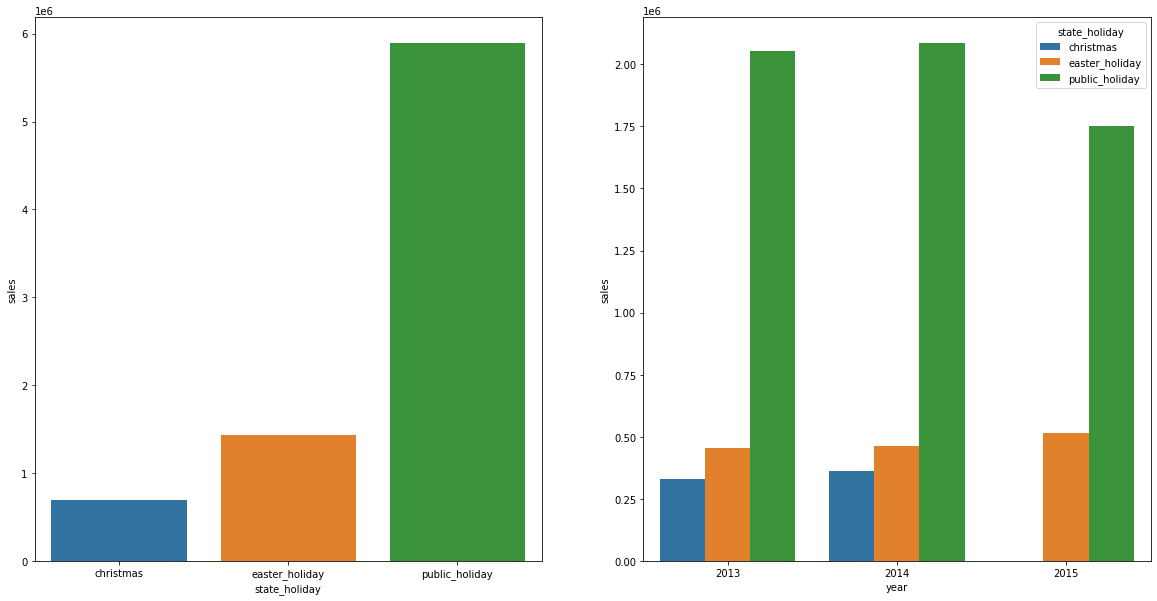

In [45]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


### H8. Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas vendem MENOS ao longo dos anos.

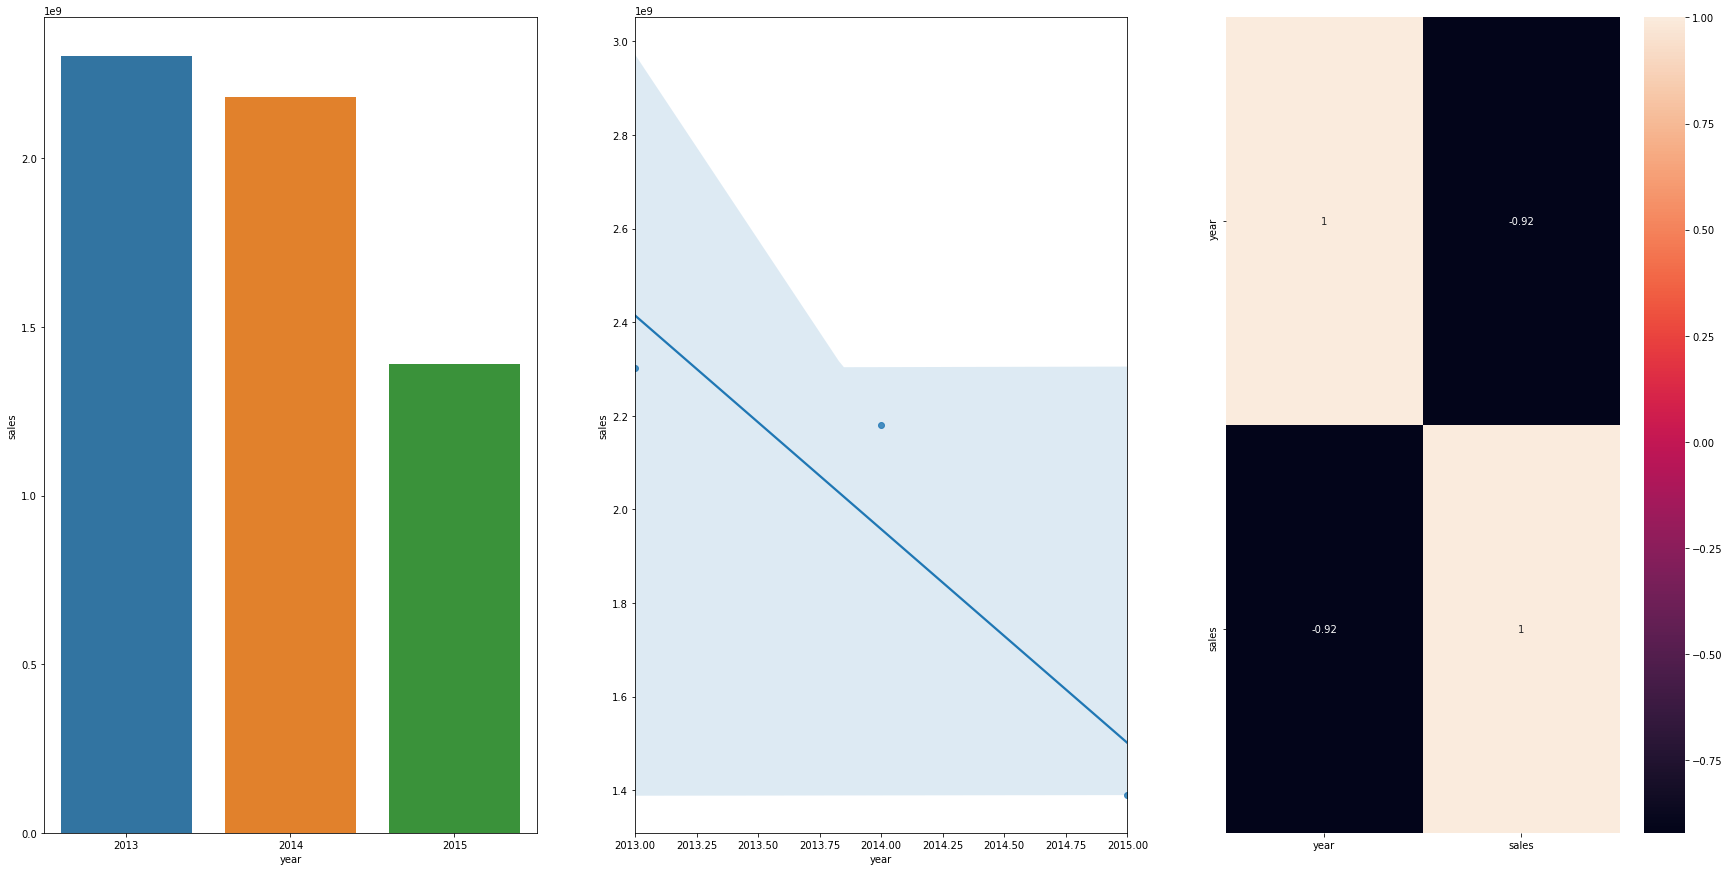

In [46]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()


plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem MENOS no segundo semestre do ano.

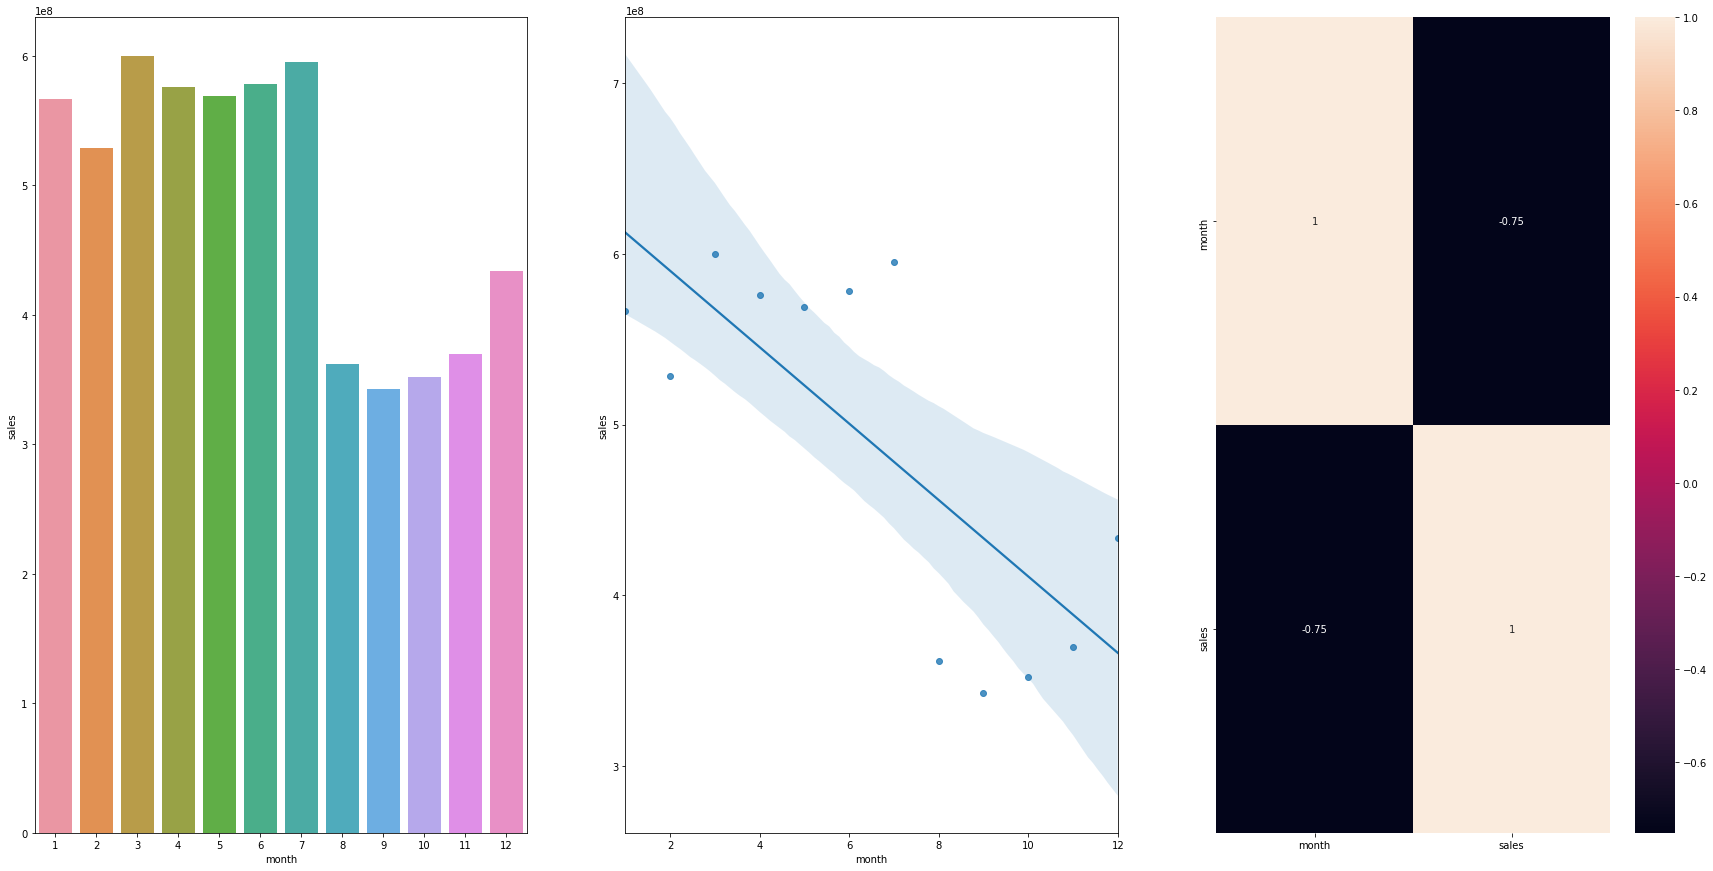

In [47]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()


plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês.

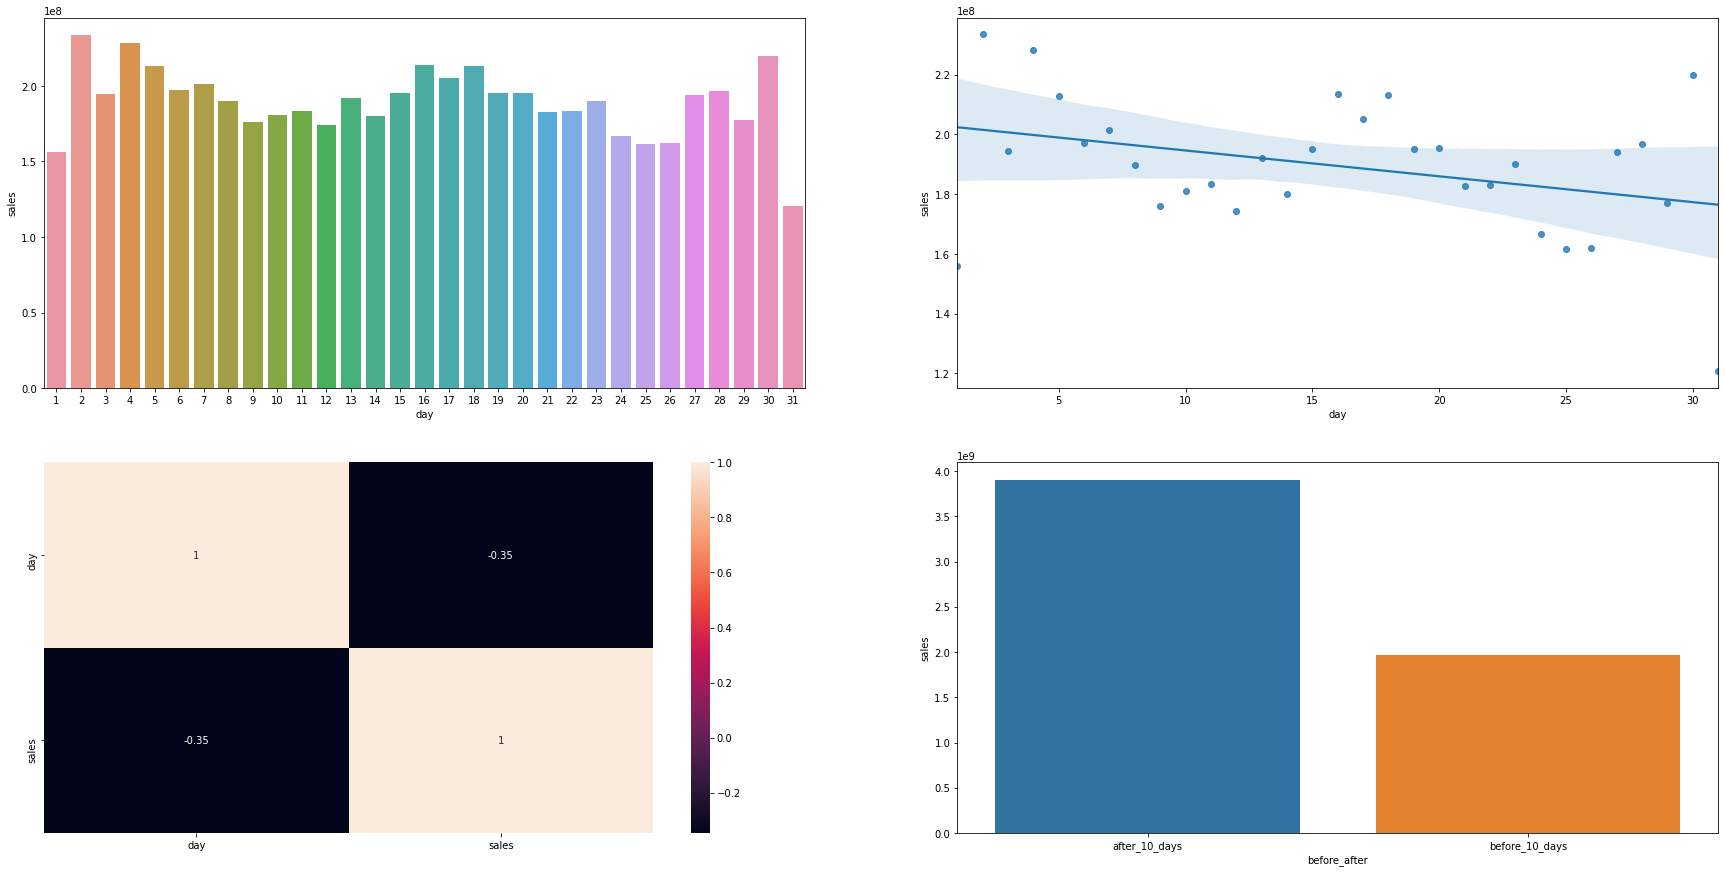

In [48]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(30, 15))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);



### H11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos aos finais de semana.

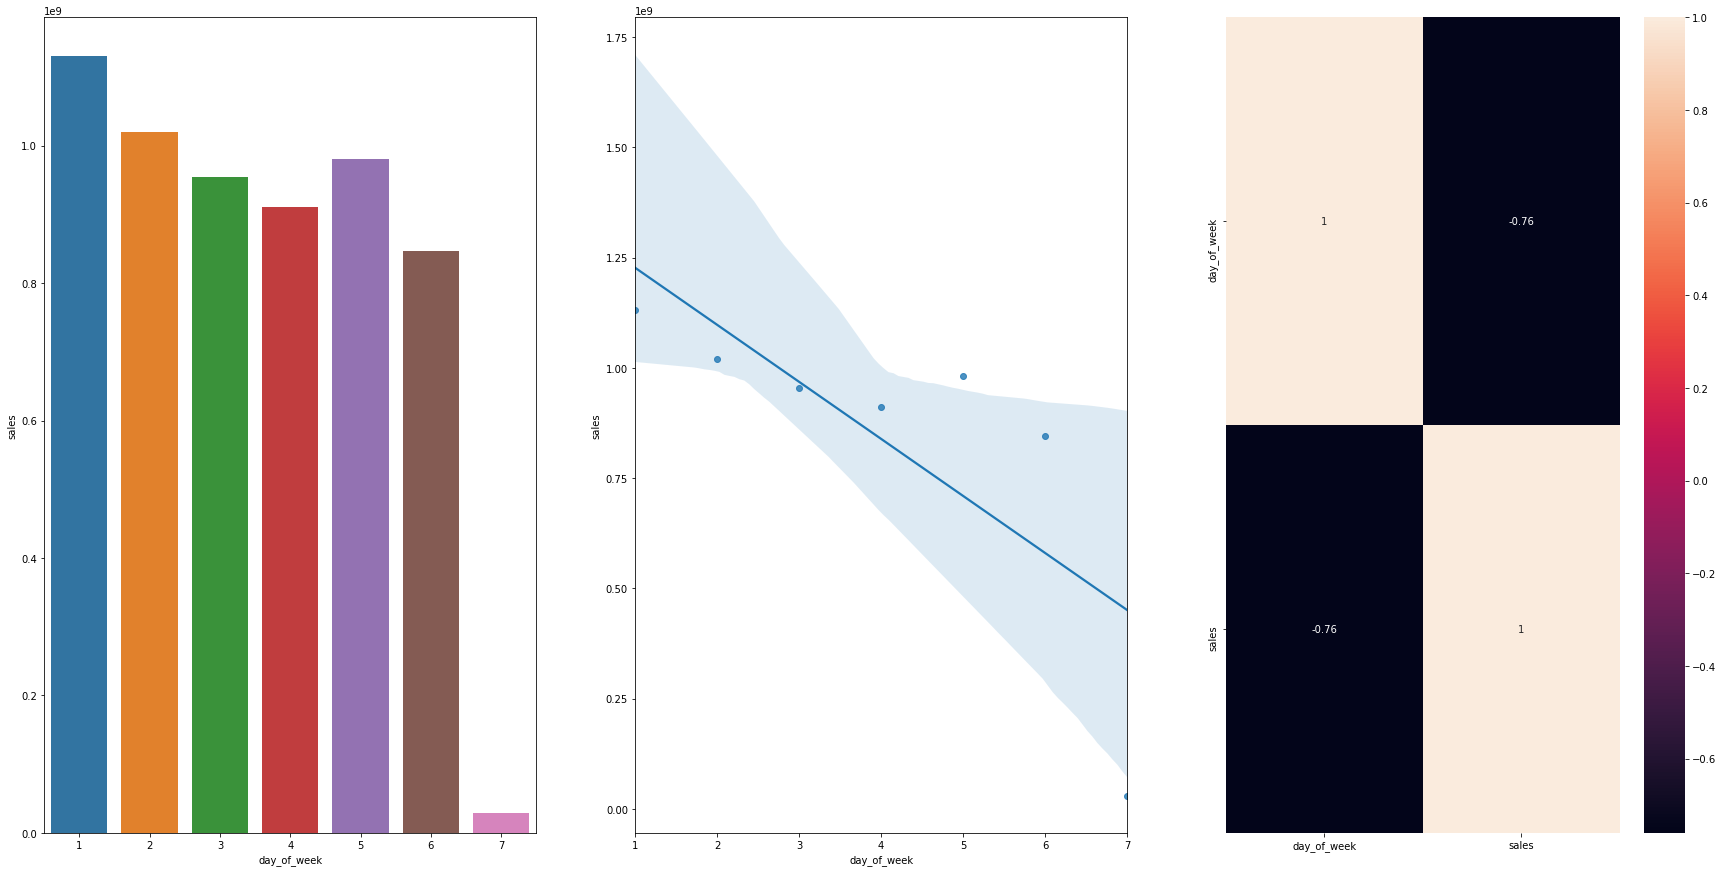

In [49]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos nos feriados escolares.

**VERDADEIRO** Lojas vendem menos nos feriados escolares, exceto nos meses de Julho e Agosto.

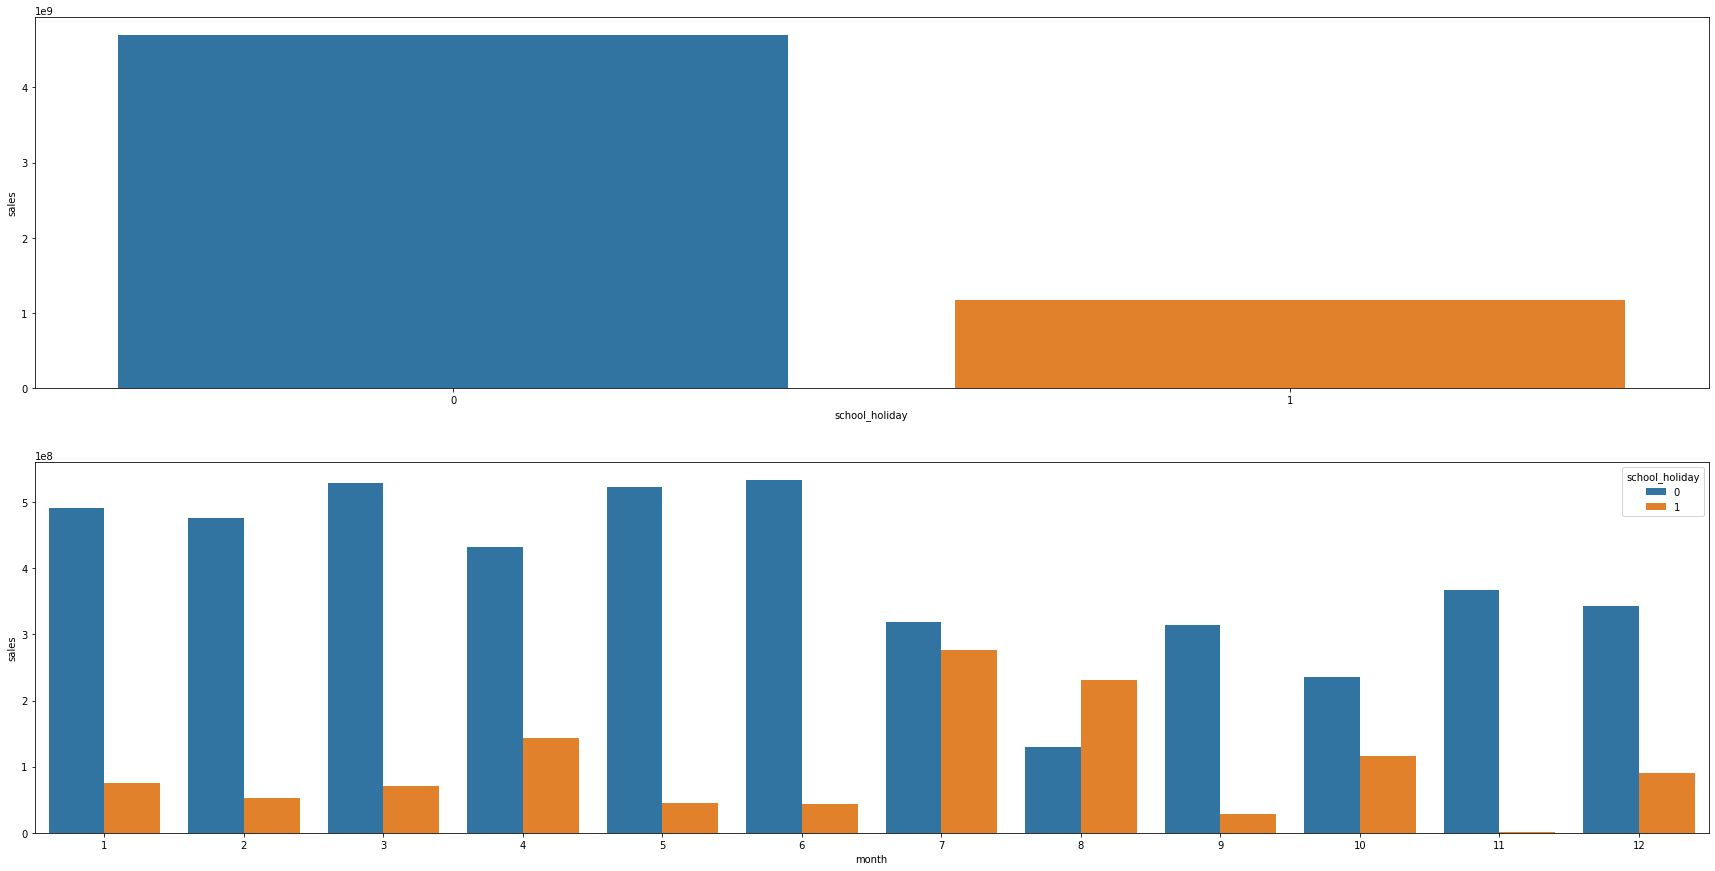

In [50]:
plt.figure(figsize=(30, 15))
plt.subplot (2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot (2,1,2)
aux2 = df4[['month' ,'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses


In [51]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Média'],
      ['H3', 'Falsa', 'Média'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Média'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
      ]

print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

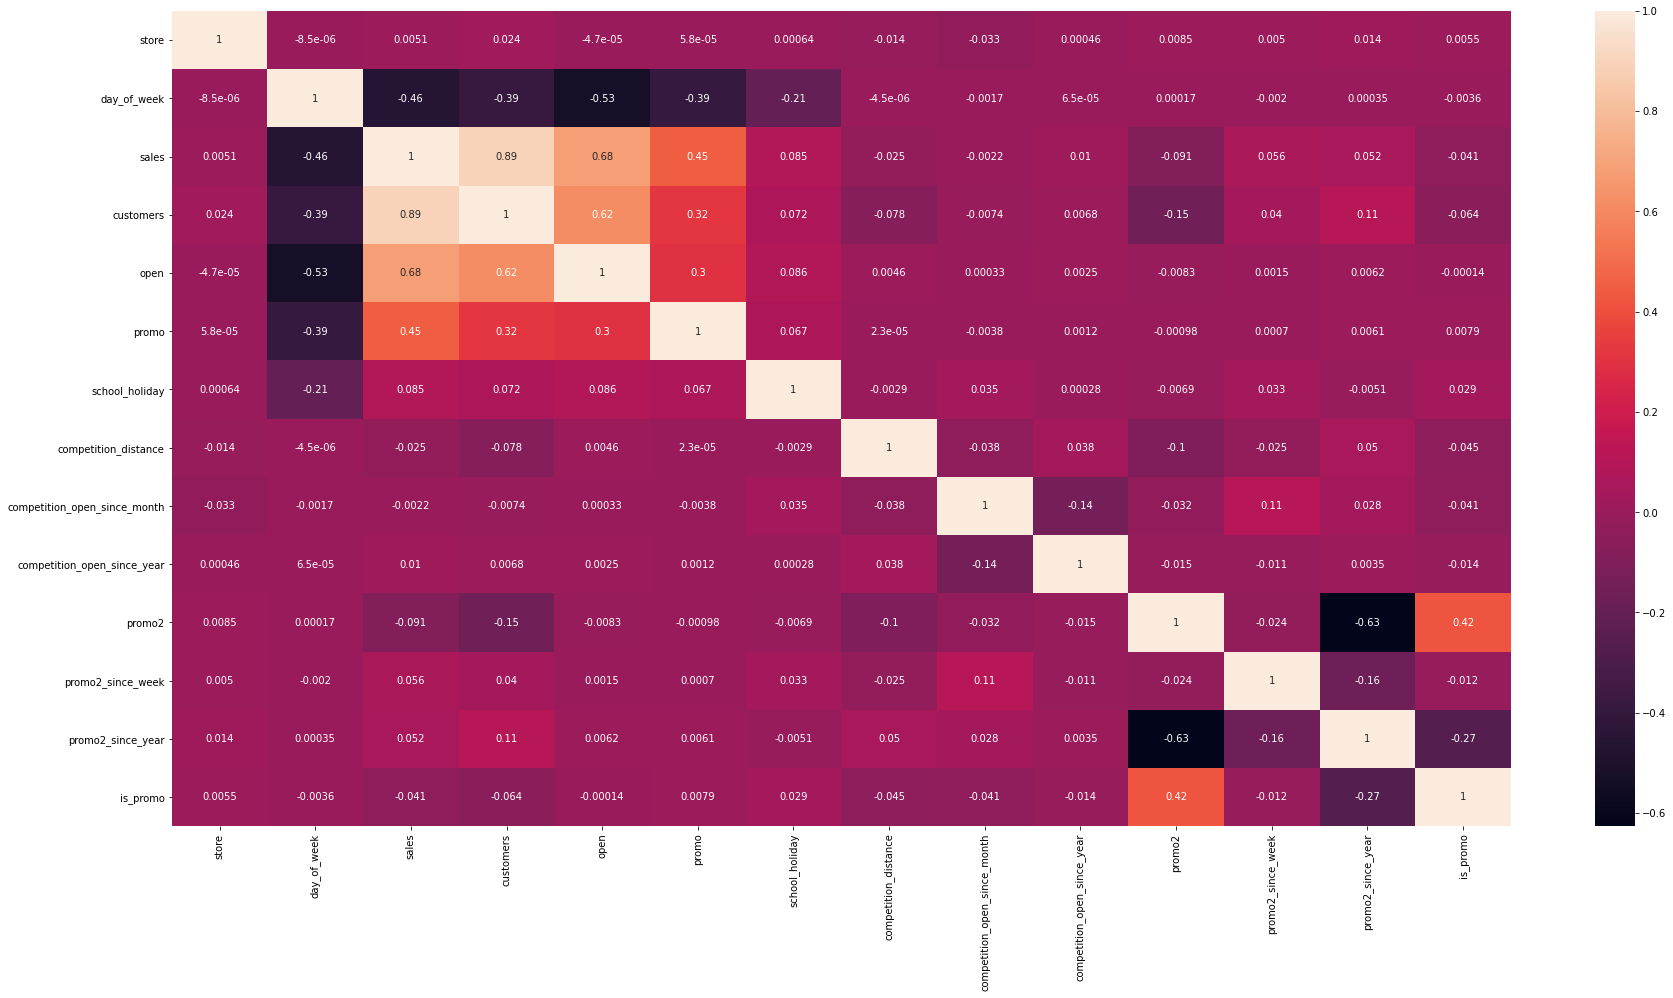

In [52]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(30, 15))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorial Attributes

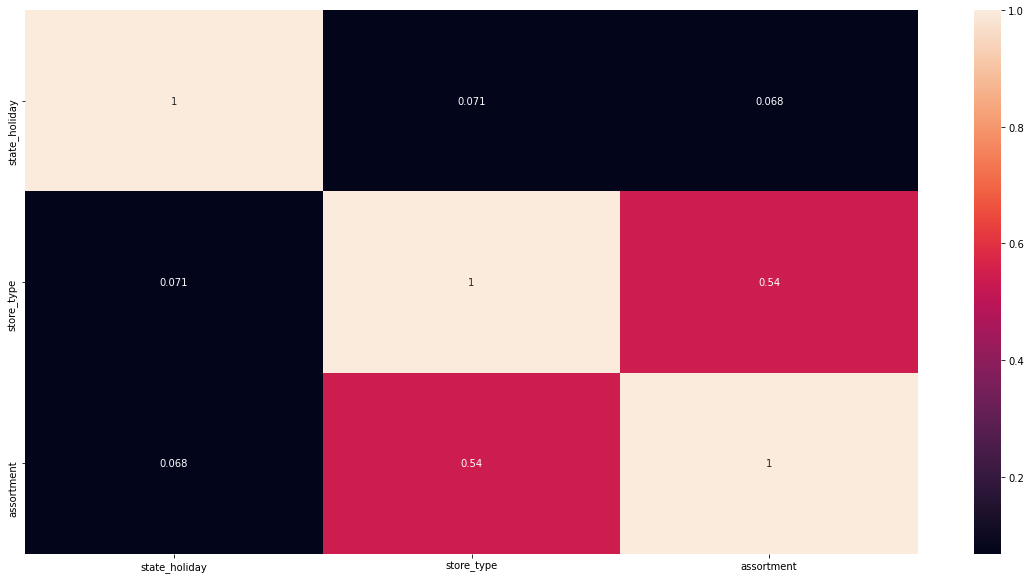

In [53]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3], 
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)

plt.figure(figsize=(20, 10))
sns.heatmap(d, annot=True);

In [54]:
 df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [55]:
# Min-Max Scaler :
# Robust Scaler :para dados com outliers muito forte

In [56]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [57]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance'>

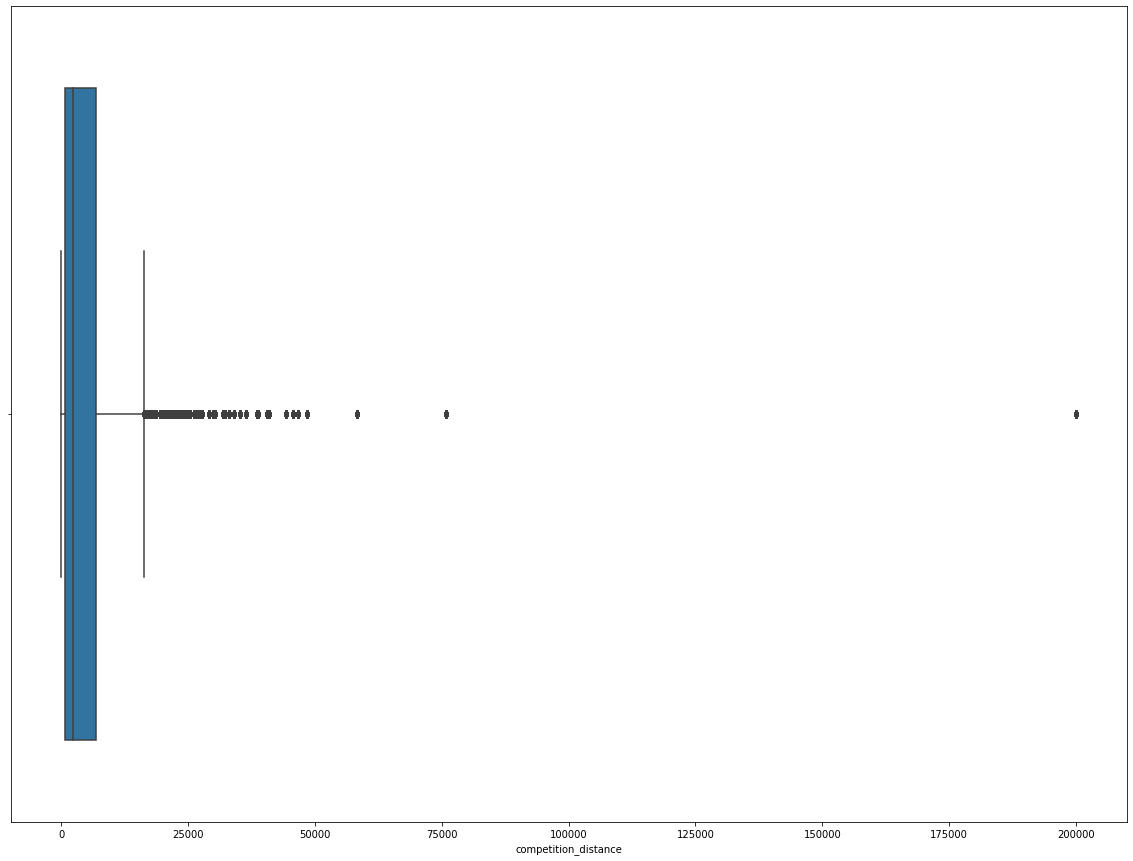

In [58]:
plt.figure(figsize=(20,15))
sns.boxplot(df5['competition_distance'])

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month'>

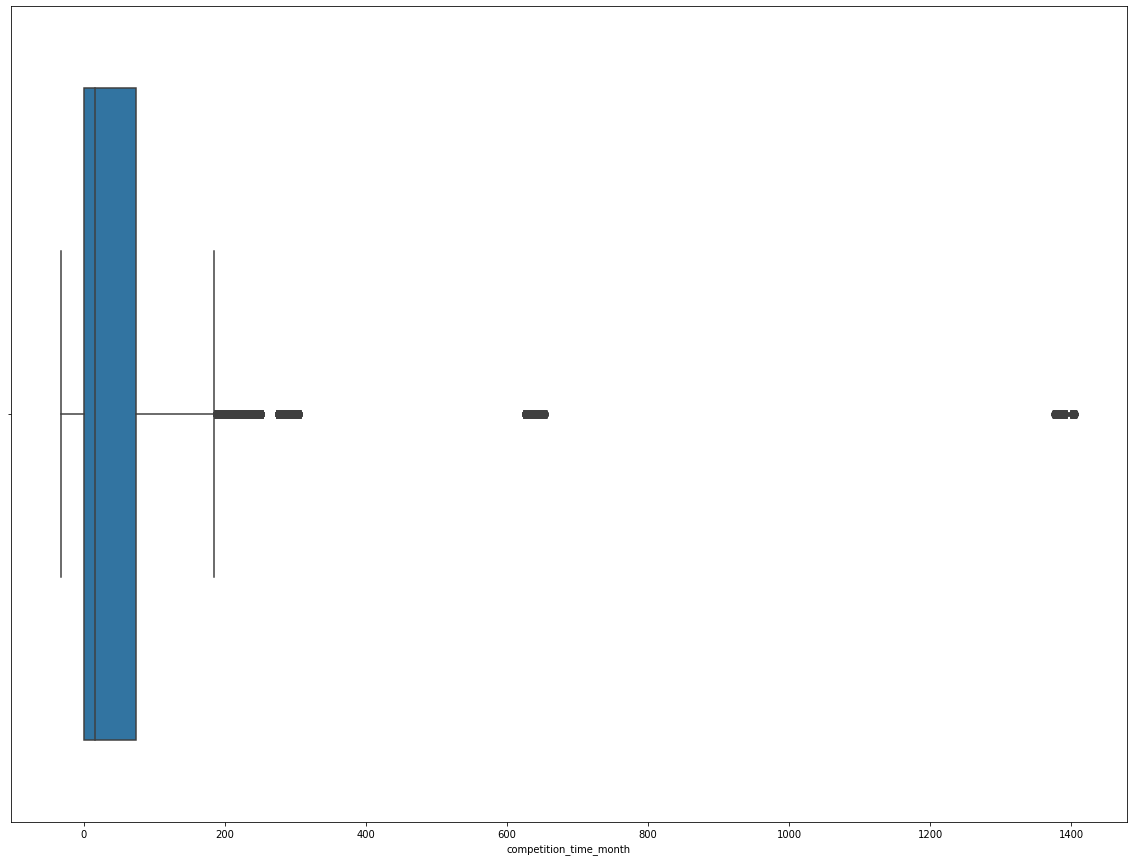

In [59]:
plt.figure(figsize=(20,15))
sns.boxplot(df5['competition_time_month'])

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

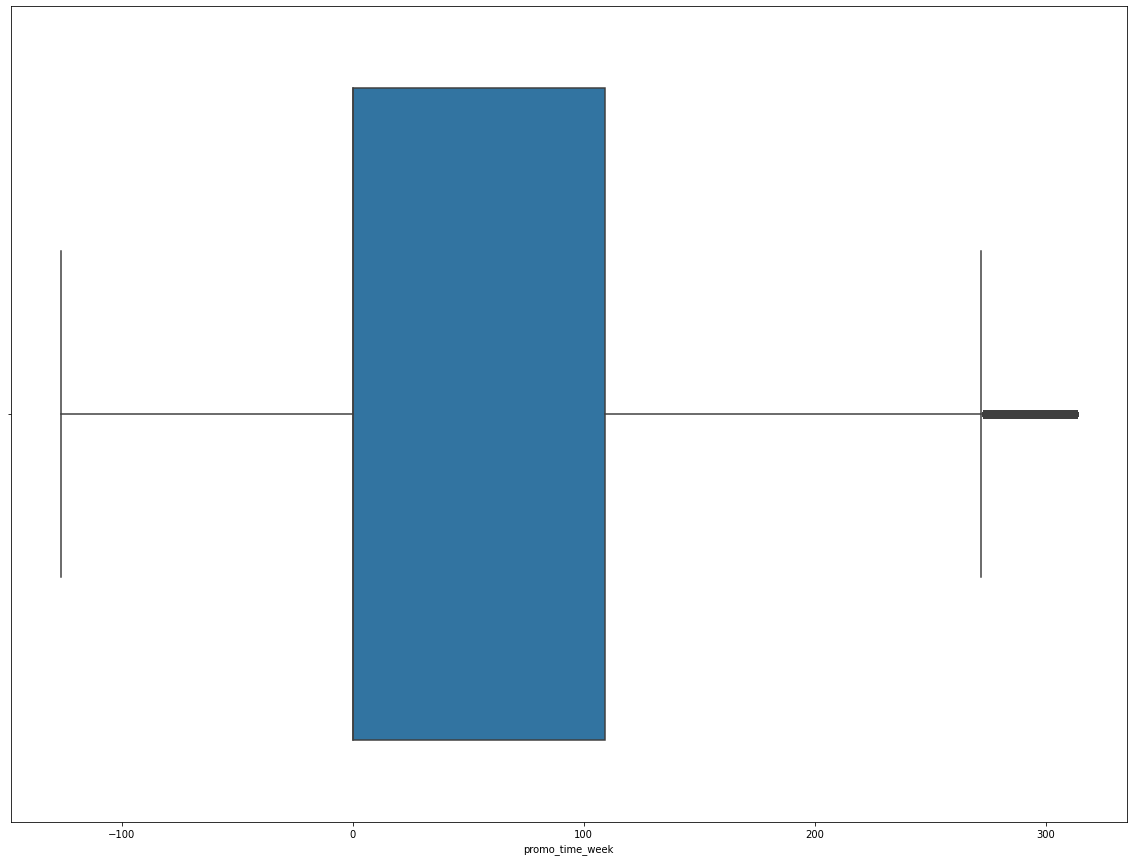

In [60]:
plt.figure(figsize=(20,15))
sns.boxplot(df5['promo_time_week'])

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

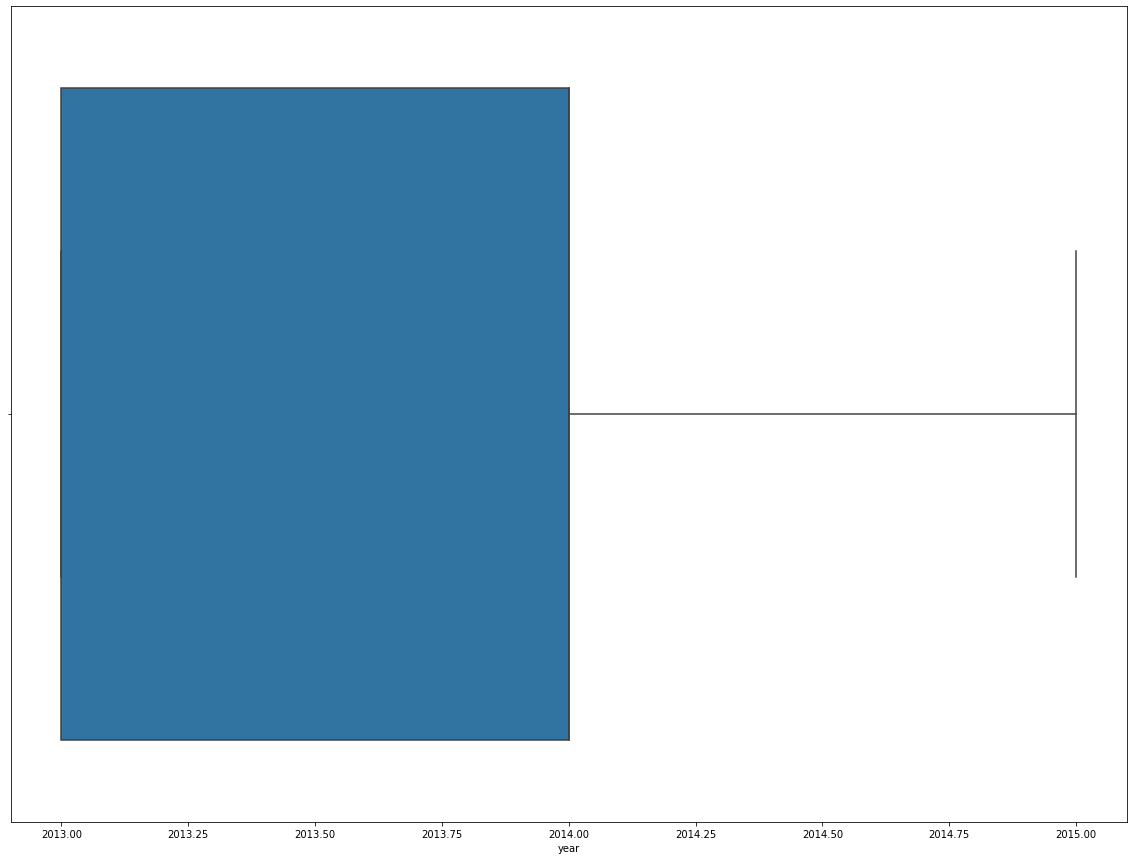

In [61]:
plt.figure(figsize=(20,15))
sns.boxplot(df5['year'])

In [62]:

rs = RobustScaler()
mms = MinMaxScaler()
# competitiion distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

# promo time week (Min-Max Scaler)
df5['competition_distance'] = mms.fit_transform(df5[['competition_distance']].values )

# year
df5['year'] = mms.fit_transform(df5[['year']].values )


/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


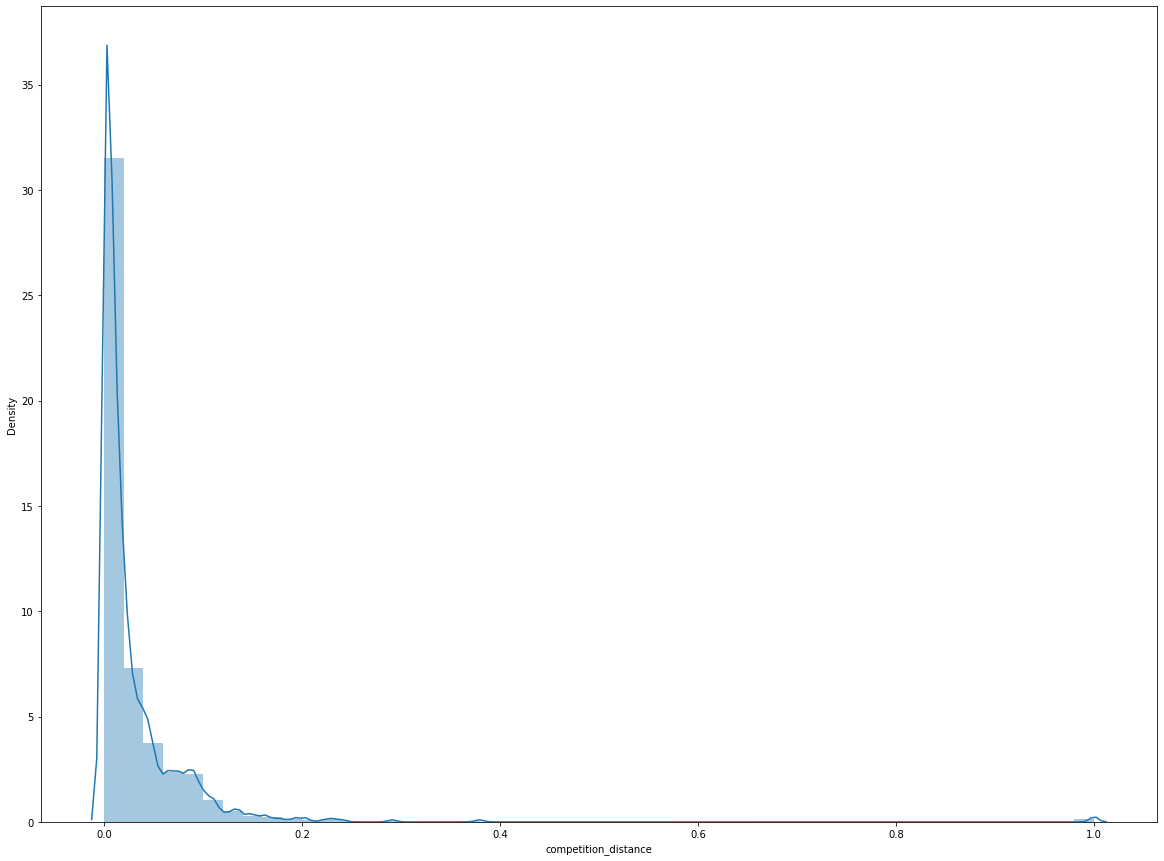

In [63]:
plt.figure(figsize=(20,15))
sns.distplot(df5['competition_distance']);

## 5.3 Transformação

### 5.3.1 Encoding

In [64]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,0.006251,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,0.002750,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,0.070557,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,0.003000,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,0.149465,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0


In [65]:
# variaveis categoricas

# state_holiday (one hot encoding)

df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type (label encoding)

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment (ordinal encoding)

assortment_dict = {'basic': 1,
                  'extra': 2,
                  'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

In [66]:
df5['sales'] = np.log1p(df5['sales'])

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

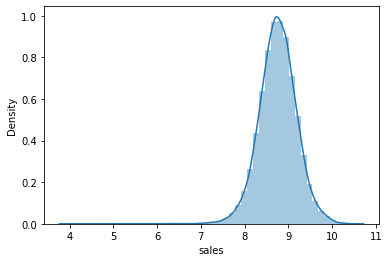

In [67]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [68]:
# variaveis de natureza ciclica

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))



In [69]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,0.006251,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,0.002750,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,0.070557,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,0.003000,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,0.149465,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [70]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test dataset

In [71]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,0.006251,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,0.002750,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,0.070557,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,0.003000,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,0.149465,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [72]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'year_week', 'competition_since']
df6 = df6.drop(cols_drop, axis=1)


In [73]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)


Timestamp('2015-06-19 00:00:00')

In [74]:
# training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']


# test dataset
 
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selection

In [75]:
#  training and test dataset for Boruta

X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [76]:
# define random forest regressor
rf = RandomForestRegressor(n_jobs=-1)

In [77]:
# define boruta

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best Features from Boruta

In [86]:
cols_selected = boruta.support_.tolist()

# best features

X_train_fs = X_train.drop(['date','sales'], axis=1)

cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))


In [89]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_cos',
     'month_sin',
     'day_sin',
     'day_cos',
     'week_of_year_cos',
     'week_of_year_sin',
     'day_of_week_sin',
     'day_of_week_cos']


# columns to add

feat_to_add = ['date', 'sales']

# final features

cols_selected_boruta.extend (feat_to_add)

In [90]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']